Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Loading and splitting dataset...
Found 4 classes: ['degeneration', 'fracture', 'misalignment', 'normal']
Total images: 1065
Splitting into 852 (train) and 213 (validation)
Setting up the model (ResNet-50)...
Starting training...
Epoch 1/50
----------
train Loss: 1.1816 Acc: 0.5059
val Loss: 1.1955 Acc: 0.4883
New best val acc: 0.4883 (saving model)

Epoch 2/50
----------
train Loss: 1.0959 Acc: 0.5458
val Loss: 1.1656 Acc: 0.4977
New best val acc: 0.4977 (saving model)

Epoch 3/50
----------
train Loss: 1.0385 Acc: 0.5469
val Loss: 1.1142 Acc: 0.5164
New best val acc: 0.5164 (saving model)

Epoch 4/50
----------
train Loss: 0.9806 Acc: 0.5669
val Loss: 1.0320 Acc: 0.5869
New best val acc: 0.5869 (saving model)

Epoch 5/50
----------
train Loss: 0.9396 Acc: 0.6127
val Loss: 1.0300 Acc: 0.5540
No improvement for 1

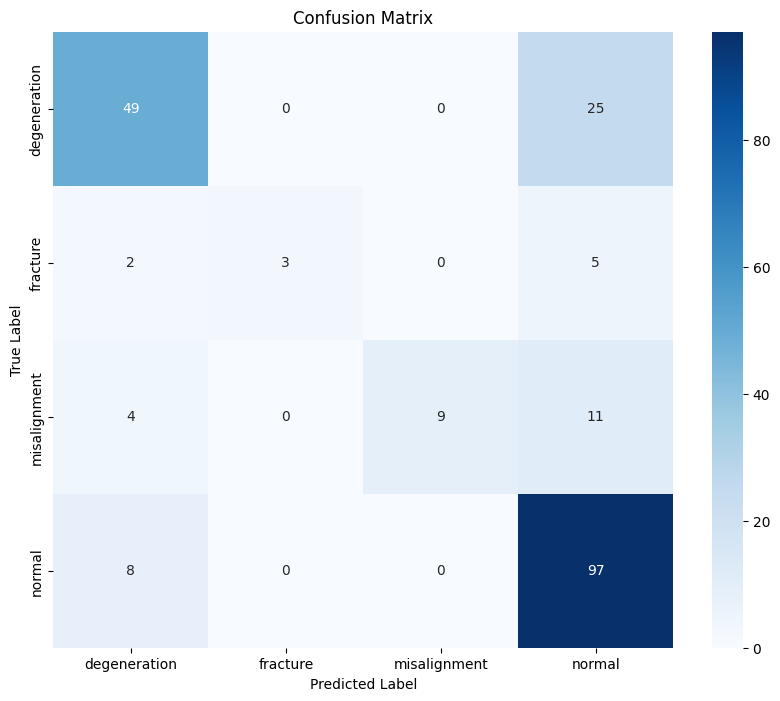

Best model successfully saved to: /content/drive/MyDrive/my_spine_classifier_best_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from google.colab import drive
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# --- 1. Mount Google Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')


# Path to dataset
data_dir = '/content/drive/MyDrive/reported_lateral'

# Path where you want to save the final, best model
save_path = '/content/drive/MyDrive/my_spine_classifier_best_model.pth'

# --- Hyperparameters ---
image_size = 224      # Image size (224x224 for ResNet)
validation_split = 0.2  # 20% of data for validation, 80% for training
batch_size = 32
num_epochs = 50       # Maximum number of epochs to run
patience = 5          # Stop if val_acc doesn't improve for 5 epochs

# --- 3. Set up Device ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 4. Define Data Transforms ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.RandomRotation(10),     # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 5. Load Dataset and Create Splits ---
print("Loading and splitting dataset...")
# Load all images from the root folder
full_dataset = ImageFolder(data_dir, transform=None) # No transforms yet
class_names = full_dataset.classes
print(f"Found {len(class_names)} classes: {class_names}")

# Calculate split sizes
total_size = len(full_dataset)
val_size = int(np.floor(validation_split * total_size))
train_size = total_size - val_size

print(f"Total images: {total_size}")
print(f"Splitting into {train_size} (train) and {val_size} (validation)")

# Split the dataset
# We use a fixed generator seed (42) for reproducible splits
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size],
                                         generator=torch.Generator().manual_seed(42))

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# --- 6. Create DataLoaders ---
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
dataset_sizes = {'train': train_size, 'val': val_size}

# --- 7. Define the Model (ResNet-50) ---
print("Setting up the model (ResNet-50)...")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all base layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classifier layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device) # Move model to GPU/CPU

# --- 8. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Tell the optimizer to only update the new, unfrozen final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# --- 9. Training Function (with Early Stopping) ---
def train_model(model, criterion, optimizer, num_epochs, patience):
    start_time = time.time()

    # Store the weights of the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Variables for Early Stopping
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize (only in train phase)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Check for improvement (only in validation phase)
            if phase == 'val':
                if epoch_acc > best_acc:
                    # New best model found
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0 # Reset counter
                    print(f'New best val acc: {best_acc:.4f} (saving model)')
                else:
                    # No improvement
                    epochs_no_improve += 1
                    print(f'No improvement for {epochs_no_improve} epoch(s).')

        print() 

        # Check for early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            print(f'Validation accuracy did not improve for {patience} consecutive epochs.')
            break # Exit the main epoch loop

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights before returning
    print("Loading best model weights...")
    model.load_state_dict(best_model_wts)
    return model

# --- 10. Start Training ---
print("Starting training...")
best_model = train_model(model, criterion, optimizer, num_epochs=num_epochs, patience=patience)
print("Training finished.")

# --- 11. Evaluate Model and Get Metrics ---
print("\nEvaluating best model on validation set...")

all_preds = []
all_labels = []

best_model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        # Move preds and labels to CPU and convert to numpy
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 12. Print Overall Accuracy ---
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Validation Accuracy: {accuracy * 100:.2f}%')

# --- 13. Calculate and Plot Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 14. Save the Final Best Model ---
torch.save(best_model.state_dict(), save_path)
print(f"Best model successfully saved to: {save_path}")